*Task 2: Lookalike Model*

In [30]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

# Load datasets
customers = pd.read_csv('Cleaned_Customers.csv')
products = pd.read_csv('Cleaned_Products.csv')
transactions = pd.read_csv('Cleaned_Transactions.csv')

# Data Preparation
# Aggregate transaction data per customer
customer_summary = transactions.groupby('CustomerID').agg(
    total_spend=('TotalValue', 'sum'),
    avg_order_value=('TotalValue', 'mean'),
    total_quantity=('Quantity', 'sum'),
    num_transactions=('TransactionID', 'count')
).reset_index()

# Merge with customer demographic and product data
transactions_with_products = transactions.merge(products, on='ProductID', how='left')
product_summary = transactions_with_products.groupby('CustomerID').agg(
    unique_categories=('Category', lambda x: x.nunique()),
    most_purchased_category=('Category', lambda x: x.mode()[0] if not x.mode().empty else 'None')
).reset_index()

customer_profile = customers.merge(customer_summary, on='CustomerID', how='left').merge(
    product_summary, on='CustomerID', how='left'
).fillna(0)

# Feature Selection for Similarity
features = ['total_spend', 'avg_order_value', 'total_quantity', 'num_transactions', 'unique_categories']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_profile[features])

# Compute Cosine Similarity
similarity_matrix = cosine_similarity(scaled_features)
similarity_df = pd.DataFrame(similarity_matrix, index=customer_profile['CustomerID'], columns=customer_profile['CustomerID'])

# Generate Lookalike Recommendations
lookalike_results = {}

for customer_id in customer_profile['CustomerID'][:20]:  # For first 20 customers (C0001 - C0020)
    similar_customers = similarity_df[customer_id].sort_values(ascending=False).iloc[1:4]  # Top 3 lookalikes (excluding the customer themselves)
    lookalike_results[customer_id] = [
        (similar_cust, round(score, 4))  # List of tuples (similar customer ID, similarity score)
        for similar_cust, score in zip(similar_customers.index, similar_customers.values)
    ]


# Function to recommend top 3 similar customers
def recommend_lookalikes(customer_id):
    # Get similarity scores for the input customer
    similar_customers = similarity_df[customer_id].sort_values(ascending=False).iloc[1:4]  # Get top 3 similar customers
    lookalikes = [
        {'SimilarCustomerID': similar_cust, 'SimilarityScore': round(score, 4)}
        for similar_cust, score in zip(similar_customers.index, similar_customers.values)
    ]
    return lookalikes

# Example usage: Recommend 3 similar customers for customer 'C0001'
customer_id = 'C0001'
lookalikes = recommend_lookalikes(customer_id)

print(f"Top 3 lookalikes for Customer {customer_id}:")
for lookalike in lookalikes:
    print(f"Customer ID: {lookalike['SimilarCustomerID']}, Similarity Score: {lookalike['SimilarityScore']}")


# Save Results to CSV as Map<cust_id, List<cust_id, score>>
lookalike_df = pd.DataFrame([
    {'CustomerID': cust, 'Lookalikes': str(lookalikes)}  # Convert list of tuples to string format
    for cust, lookalikes in lookalike_results.items()
])

lookalike_df.to_csv('SREYA_MONDAL_Lookalike.csv', index=False)

# Output Sample Recommendations
print("Sample Lookalike Recommendations:")
print(lookalike_df.head())

Top 3 lookalikes for Customer C0001:
Customer ID: C0164, Similarity Score: 0.9709
Customer ID: C0189, Similarity Score: 0.9281
Customer ID: C0118, Similarity Score: 0.8991
Sample Lookalike Recommendations:
  CustomerID                                         Lookalikes
0      C0001  [('C0164', 0.9709), ('C0189', 0.9281), ('C0118...
1      C0002  [('C0199', 0.9919), ('C0010', 0.9776), ('C0142...
2      C0003  [('C0027', 0.8539), ('C0166', 0.7078), ('C0129...
3      C0004  [('C0165', 0.9899), ('C0156', 0.9849), ('C0195...
4      C0005  [('C0131', 0.9972), ('C0159', 0.9963), ('C0130...


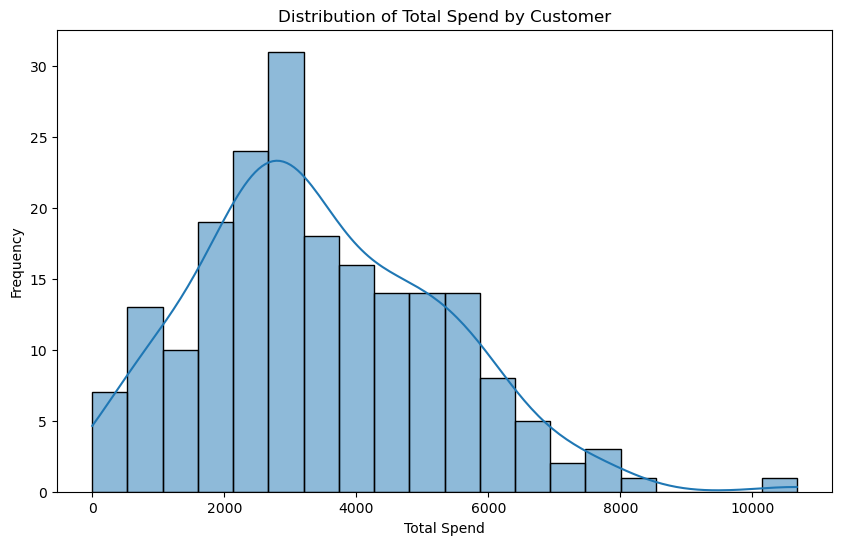

In [31]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Handle inf values by converting them to NaN
customer_profile['total_spend'] = customer_profile['total_spend'].replace([float('inf'), -float('inf')], float('nan'))

# Plotting distribution of total spend across all customers
plt.figure(figsize=(10, 6))
sns.histplot(customer_profile['total_spend'], kde=True, bins=20)
plt.title("Distribution of Total Spend by Customer")
plt.xlabel("Total Spend")
plt.ylabel("Frequency")
plt.show()
